In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
pybn_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/pyBN-master'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
if pybn_dir not in sys.path:
    sys.path.append(pybn_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from latent_nce_optimiser import LatentNCEOptimiser, CDOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

# Setup

In [3]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1  # ratio of noise to data samples for NCE
num_gibbs_steps_for_synthetic_data = 200
d = 10  # visible dimension
m = 5  # latent dimension
true_W = np.zeros((d+1, m+1))
for i in range(m):
    true_W[:, i] = rnd.uniform(-1/(i+1), 1/(i+1), d+1)  # true setting of the weights, that we are trying to learn
theta0 = rnd.randn(d+1, m+1)*0.01  # random initialisation of weights
#theta0 = true_W

In [4]:
# tolerances used to determine when iterations stop in scipy minimize (used in LatentNCEOptimiser)
gtol = 1e-5
ftol = 1e-5
# threshold for stopping EM outer loop of optimisation in LatentNCEOptimiser
stop_threshold =  1e-03
# maximum number of EM steps
max_num_em_steps = 20

# hyperparameters used in CDOptimiser (contrastive divergence optimiser)
cd_num_steps = 1
cd_learn_rate = 0.001
cd_batch_size = 10

#### Switches

In [5]:
init_scaling_param_at_data_dist_scale = False
init_scaling_param_at_rnd_init_scale = True
init_visible_biases_with_entropy = False

# Data, Model & Optimiser definition

#### sample a synthetic dataset

In [6]:
%%time
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=num_gibbs_steps_for_synthetic_data)

CPU times: user 935 ms, sys: 46.3 ms, total: 981 ms
Wall time: 970 ms


In [7]:
# initialise visible biases as recommended by Hinton
X_mean = np.mean(X, axis=0)
if init_visible_biases_with_entropy:
    theta0[1:, 0] = np.log(X_mean / (1 - X_mean))

#### compute the true normalisation constant

In [8]:
%%time
true_data_dist.reset_norm_const()
true_norm_const = true_data_dist.norm_const
true_W[0, 0] = -np.log(true_norm_const)
print(-np.log(true_norm_const))

-10.156997136783668
CPU times: user 927 µs, sys: 0 ns, total: 927 µs
Wall time: 665 µs


In [9]:
# initialise three models for comparison
model = RestrictedBoltzmannMachine(theta0)
cd_model = RestrictedBoltzmannMachine(theta0)
random_init_model = RestrictedBoltzmannMachine(theta0)

In [10]:
random_init_model.reset_norm_const()
rnd_norm_const = random_init_model.norm_const
print(-np.log(rnd_norm_const))

-10.389940258788892


In [11]:
noise = MultivariateBernoulliNoise(X_mean)
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

In [12]:
%%time
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(cd_model)

CPU times: user 1.17 ms, sys: 35 µs, total: 1.21 ms
Wall time: 1.02 ms


# Optimisation

In [13]:
if init_scaling_param_at_data_dist_scale:
    theta0[0, 0] = -np.log(true_norm_const)
if init_scaling_param_at_rnd_init_scale:
    theta0[0, 0] = -np.log(rnd_norm_const)

In [14]:
all_inds = np.arange(len(model.theta))

In [15]:
%%time
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(all_inds, X, theta0=theta0.reshape(-1), 
                                                                     stop_threshold=stop_threshold, 
                                                                     max_num_em_steps=max_num_em_steps,
                                                                     gtol=gtol, ftol=ftol, plot=False, 
                                                                     disp=True)
latent_nce_estimate = model.theta

CPU times: user 1.56 s, sys: 242 ms, total: 1.81 s
Wall time: 1.79 s


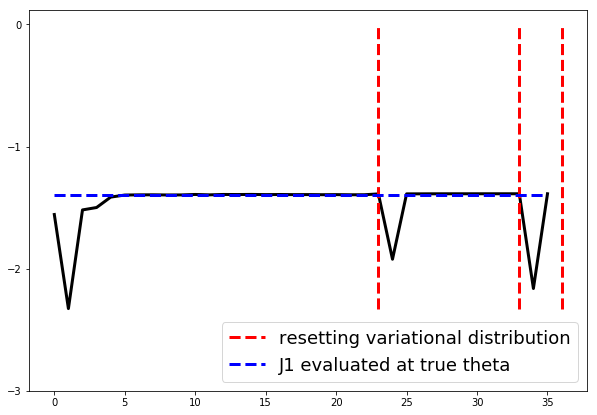

In [16]:
fig, ax = optimiser.plot_loss_curve(J1s, plot_reset_points=True, endpoints=None, 
                                    true_theta = true_W.reshape(-1), X=X)

In [17]:
J1_len = sum([len(i) for i in J1s])
# fig, ax = optimiser.plot_loss_curve(J1s, endpoints=(5, J1_len), true_theta = true_W.reshape(-1), X=X)

In [18]:
%%time
thetas_after_each_minibatch = cd_optimiser.fit(X, theta0=theta0.reshape(-1), num_gibbs_steps=cd_num_steps,
                                               learning_rate=cd_learn_rate, batch_size=cd_batch_size)
cd_estimate =  cd_model.theta

CPU times: user 172 ms, sys: 18.3 ms, total: 190 ms
Wall time: 172 ms


# Results

## Log-likelihood on training set

### $ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [19]:
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
cd_probs_of_true_data, _ = cd_model.normalised_and_marginalised_over_z(X)
random_probs_of_true_data, _ = random_init_model.normalised_and_marginalised_over_z(X)
print('True:       {} \nLatent NCE: {} \nCD:         {}\nRandom init:{} '.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data))
))

True:       -6.611525557901425 
Latent NCE: -6.613125246993808 
CD:         -6.726130318457977
Random init:-6.935411110451212 


## L1 norm between model joint & true joint

$$ \| \phi - p_{data} \|_1 = \sum_{\textbf{v} \in \{0,1\}^{d}} \sum_{\textbf{h} \in \{0,1\}^{m}} |\phi(\textbf{v}, \textbf{h}) - p_{data}(\textbf{v}, \textbf{h}) | $$

In [20]:
true_model_vals = true_data_dist.evaluate_on_entire_domain(normalise=True)
latent_nce_vals = model.evaluate_on_entire_domain(normalise=False)
cd_vals = cd_model.evaluate_on_entire_domain(normalise=True)
rnd_init_vals = random_init_model.evaluate_on_entire_domain(normalise=True)

l1_norm_diff_true_nce = np.sum(np.abs(true_model_vals - latent_nce_vals))
l1_norm_diff_true_cd = np.sum(np.abs(true_model_vals - cd_vals))
l1_norm_diff_true_rnd_init = np.sum(np.abs(true_model_vals - rnd_init_vals))

print('true vs latent nce:   {}'.format(l1_norm_diff_true_nce))
print('true vs cd:           {}'.format(l1_norm_diff_true_cd))
print('true vs random init:  {}'.format(l1_norm_diff_true_rnd_init))

true vs latent nce:   0.3310052719566911
true vs cd:           0.47005882653260944
true vs random init:  0.6899335798070042


## Frobenius norm of true parameters minus model parameters

In [21]:
# NOTE: we exclude the scaling parameter in all comparisons

random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5
nce_true_param_diff = (true_W - latent_nce_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5
cd_true_param_diff = (true_W - cd_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5
print('true vs latent nce:   {}'.format(sq_diff_nce_true))
print('true vs cd:           {}'.format(sq_diff_cd_true))
print('true vs random init:  {}'.format(sq_diff_rand_true))

true vs latent nce:   1.8322448549534538
true vs cd:           1.9848679842358856
true vs random init:  2.1758098525109983


### Scaling parameter

In [22]:
print('Learnt Scaling param is:              {}'.format(latent_nce_estimate[0]))
print('Norm const of data distribution is:   {}'.format(-np.log(true_norm_const)))

Learnt Scaling param is:              -10.166332513728705
Norm const of data distribution is:   -10.156997136783668


## Visualisations of parameters

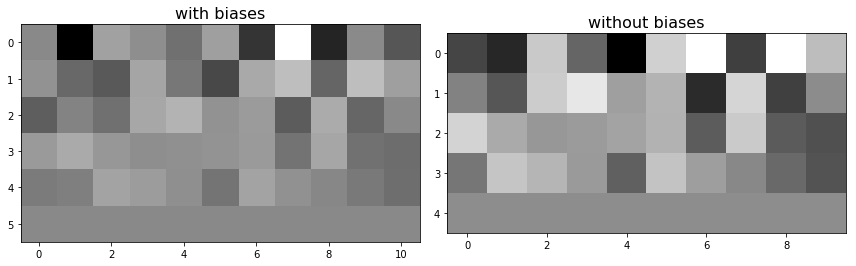

In [23]:
true_params = np.array(true_data_dist.theta.reshape(d+1, m+1).T)
true_params[0,0] = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(true_params, cmap='gray')
axs[1].imshow(true_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('True parameters', fontsize=20)
plt.tight_layout()

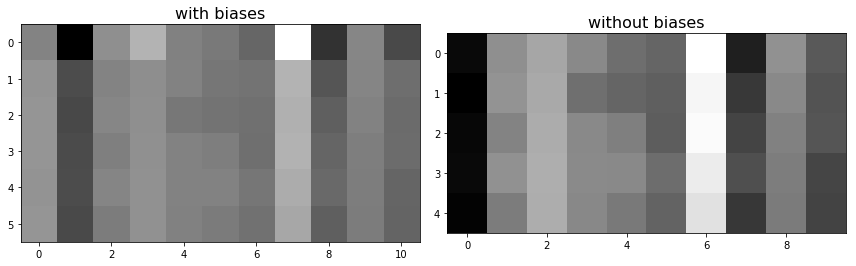

In [24]:
nce_params = np.array(model.theta.reshape(d+1, m+1).T)
nce_params[0,0] = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(nce_params, cmap='gray')
axs[1].imshow(nce_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
# fig.suptitle('Latent NCE parameters', fontsize=20)
plt.tight_layout()

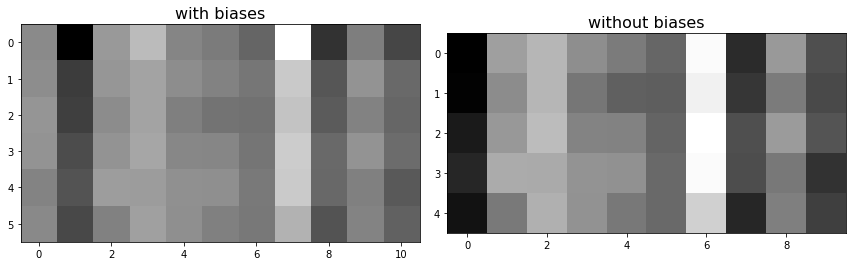

In [25]:
cd_params = np.array(cd_model.theta.reshape(d+1, m+1).T)
cd_params[0,0] = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(cd_params, cmap='gray')
axs[1].imshow(cd_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('Contrastive Divergence parameters', fontsize=20)
plt.tight_layout()

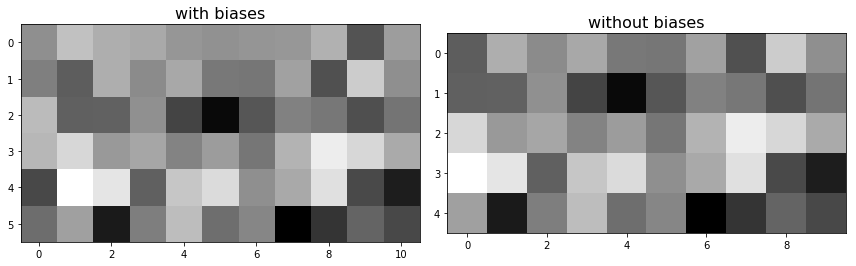

In [26]:
rnd_params = np.array(random_init_model.theta.reshape(d+1, m+1).T)
rnd_params[0,0] = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.ravel()
axs[0].imshow(rnd_params, cmap='gray')
axs[1].imshow(rnd_params[1:, 1:], cmap='gray')
axs[0].set_title('with biases', fontsize=16)
axs[1].set_title('without biases', fontsize=16)
#fig.suptitle('Initial parameters', fontsize=20)
plt.tight_layout()

In [27]:
print(nce_params[1:, 0])

[0.06274288 0.06987307 0.06862031 0.06342647 0.0700054 ]


In [28]:
print(nce_params[0,1:])

[-0.53150885  0.04691063  0.19117813 -0.0110435  -0.04451136 -0.11982384
  0.49790737 -0.32747862  0.00866052 -0.23231738]


In [29]:
print(nce_params[1:,1:])

[[-0.22449274  0.00214572  0.04154021 -0.00841099 -0.0535937  -0.06885205
   0.19337867 -0.18850617  0.00615013 -0.08786307]
 [-0.2411339   0.01124369  0.04724959 -0.0512699  -0.0685568  -0.0795782
   0.17692978 -0.14555446 -0.00792703 -0.09941982]
 [-0.22813533 -0.01786047  0.05112319 -0.0076399  -0.02410843 -0.08298615
   0.18604338 -0.12498563 -0.02100036 -0.09534768]
 [-0.22530772  0.00548371  0.05461546 -0.00535484 -0.00849135 -0.05559256
   0.16044167 -0.1066625  -0.02753767 -0.12347905]
 [-0.23505753 -0.02907163  0.05333313 -0.00945585 -0.03298068 -0.07293082
   0.14221211 -0.14772424 -0.03103603 -0.12660504]]


In [30]:
for i in range(1,6):
    print(np.sum(nce_params[i, 1:]))

-0.38850400553840864
-0.45801705226510364
-0.3648973848017519
-0.3318848437558656
-0.48931657853520305


In [31]:
np.log(X_mean/(1-X_mean))

array([-1.07370044,  0.04280654,  0.30228087, -0.05521402, -0.11653169,
       -0.30432722,  0.87844556, -0.64906619, -0.05801627, -0.4976206 ])

# Validation of synthetic dataset

In [32]:
"""all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))
print('normalisation constant is: {}'.format(true_dist_norm_const))

all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""

"all_visibles = true_data_dist.get_all_binary_vectors(d)\nvisible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)\nprint('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))\n\nprint('-------------------------Visible probability checks--------------------------------------')\nfor i in range(2**d):\n    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)\n    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], \n                                                                         freq, visible_probs[i]))\nprint('normalisation constant is: {}'.format(true_dist_norm_const))\n\nall_hiddens = true_data_dist.get_all_binary_vectors(m)\nhidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)\n\nprint('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))\n\nvar_dist.alpha = true_W.reshape(-1)\nZ_fr